# First Test of Comapring New Method to Actual SHAP Values

## Setup

In [1]:
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from siuba import _, select

## Data

In [2]:
# Set the Seed
np.random.seed(25)

# Get the Predictors
x1 = np.random.uniform(low = 0, high = 1, size = 10000)
x2 = np.random.uniform(low = 0, high = 1, size = 10000)
d = {"x1":x1, "x2":x2}
X = pd.DataFrame(data = d)

# Get the three different responses
y1 = x1 + x2
y2 = 2 * x1 + 2 * x2
y3 = (x1 + x2) * (2 * x1 + 2 * x2)

# Make the data for the 3 models
d1 = xgb.DMatrix(X, label=y1)
d2 = xgb.DMatrix(X, label=y2)
d3 = xgb.DMatrix(X, label=y3)

X.head()

,x1,x2
0,0.870124,0.219242
1,0.582277,0.648587
2,0.278839,0.288863
3,0.185911,0.313272
4,0.411100,0.561066


## Models

In [3]:
param = {'max_depth': 5, 'eta': 0.3, 'objective': 'reg:squarederror', "eval_metric":"mae", "alpha":0.1, "gamma":0.1}

bst1 = xgb.train(param, d1, 10)
bst2 = xgb.train(param, d2, 10)
bst3 = xgb.train(param, d3, 10)

## SHAP Values

In [4]:
shap1_ex = shap.TreeExplainer(bst1)
shap1 = shap1_ex.shap_values(X)
shap2_ex = shap.TreeExplainer(bst2)
shap2 = shap2_ex.shap_values(X)
shap3_ex = shap.TreeExplainer(bst3)
shap3 = shap3_ex.shap_values(X)

### SHAP Visualizations for the 3 Models

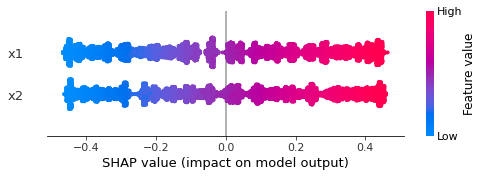

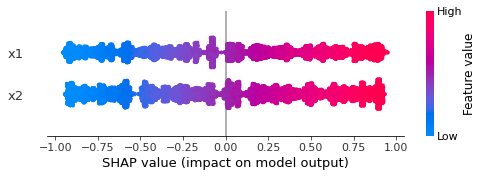

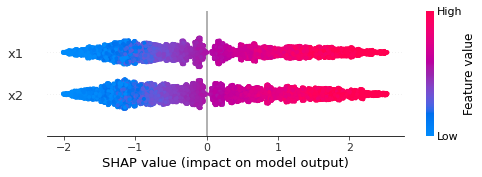

In [5]:
#shap.initjs()

shap.summary_plot(shap1, X)
shap.summary_plot(shap2, X)
shap.summary_plot(shap3, X)

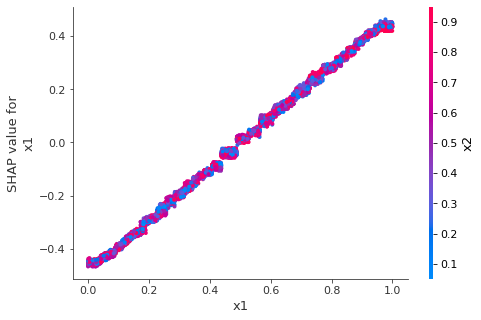

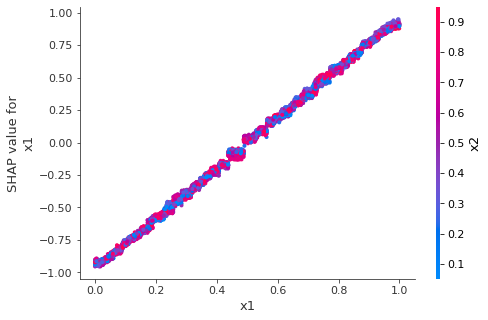

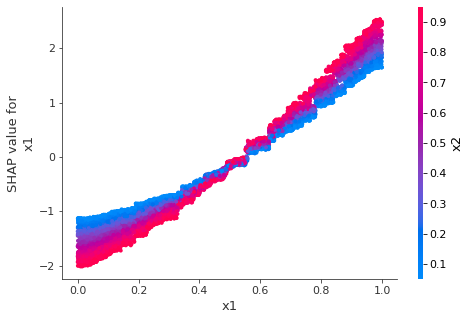

In [6]:
shap.dependence_plot("x1", shap1, X)
shap.dependence_plot("x1", shap2, X)
shap.dependence_plot("x1", shap3, X)

In [9]:
shap.force_plot(shap3_ex.expected_value, shap3[100,:], X.iloc[100,:])

shap.force_plot(shap3_ex.expected_value, shap3[:1000, :], X.iloc[:1000, :])

### New Multiplicative Method

In [7]:
print(np.shape(shap1))
print(np.shape(shap2))
np.shape(shap1)[1]

(10000, 2)
(10000, 2)


2

In [8]:
shap1[:,0]

array([ 0.3476479 ,  0.0685757 , -0.21134458, ..., -0.37291273,
        0.35741574,  0.13602614], dtype=float32)

In [9]:
shap2[:,0]

array([ 0.6997788 ,  0.13685663, -0.4191981 , ..., -0.7436966 ,
        0.7099125 ,  0.25650245], dtype=float32)

In [10]:
shap1[:,0] * shap2[:,0]

array([0.24327663, 0.00938504, 0.08859525, ..., 0.27733392, 0.2537339 ,
       0.03489104], dtype=float32)

In [11]:
np.arange(0,2)

array([0, 1])

In [12]:
np.savetxt("shap1.csv", shap1, delimiter = ",")
np.savetxt("shap2.csv", shap2, delimiter = ",")
np.savetxt("shap3.csv", shap3, delimiter = ",")

In [13]:
multi_shap1 = (shap1[:,0] * shap2[:,0] + shap1[:,0] * shap2[:,1] + shap1[:,0] * shap2_ex.expected_value + 
               shap2[:,0] * shap1[:,0] + shap2[:,0] * shap1[:,1] + shap2[:,0] * shap1_ex.expected_value) / 2
multi_shap2 = (shap1[:,1] * shap2[:,0] + shap1[:,1] * shap2[:,1] + shap1[:,1] * shap2_ex.expected_value + 
               shap2[:,1] * shap1[:,0] + shap2[:,1] * shap1[:,1] + shap2[:,1] * shap1_ex.expected_value) / 2
multi_shap3 = (shap1_ex.expected_value * shap2[:,0] + shap1_ex.expected_value * shap2[:,1] + shap1_ex.expected_value * shap2_ex.expected_value + 
               shap2_ex.expected_value * shap1[:,0] + shap2_ex.expected_value * shap1[:,1] + shap2_ex.expected_value * shap1_ex.expected_value) / 2

In [14]:
print(bst3.predict(d1))
print(multi_shap1 + multi_shap2 + multi_shap3)
print(shap3[:,0] + shap3[:,1] + shap3_ex.expected_value)

[2.299291   3.0019693  0.62150556 ... 1.380363   2.789602   1.9710042 ]
[2.1879368 2.8374395 0.6677294 ... 1.298998  2.7643096 1.8055539]
[2.2992907 3.0019693 0.6215055 ... 1.380363  2.789602  1.9710044]


In [16]:
new_shap = pd.DataFrame(data = {"x1":multi_shap1, "x2":multi_shap2, "baseline":multi_shap3})
new_shap.head

<bound method NDFrame.head of             x1        x2  baseline
0     0.729587 -0.608502  2.066851
1     0.163186  0.320531  2.353723
2    -0.243224 -0.230855  1.141808
3    -0.309702 -0.178247  0.994316
4    -0.188118  0.091536  1.850602
...        ...       ...       ...
9995  1.369468  0.852998  3.276771
9996  0.019073 -0.359676  1.513006
9997 -0.600226  0.306648  1.592576
9998  0.837506 -0.396415  2.323218
9999  0.251041 -0.323098  1.877611

[10000 rows x 3 columns]>

In [17]:
new_shap_1 = pd.DataFrame.to_numpy(new_shap)

In [18]:
new_shap_final = new_shap_1[:,:-1]

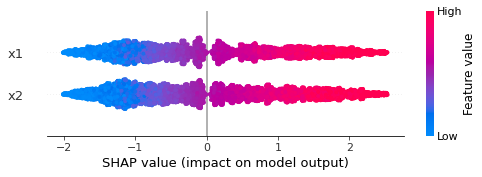

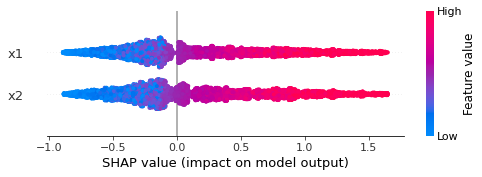

In [19]:
shap.summary_plot(shap3, X)
shap.summary_plot(new_shap_final, X)

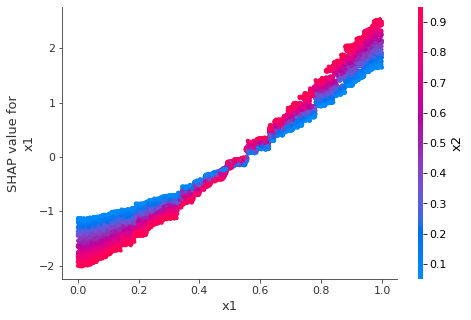

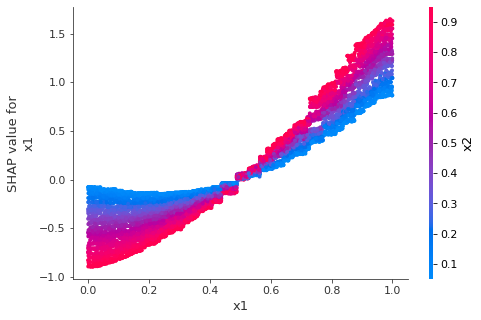

In [20]:
shap.dependence_plot("x1", shap3, X)
shap.dependence_plot("x1", new_shap_final, X)

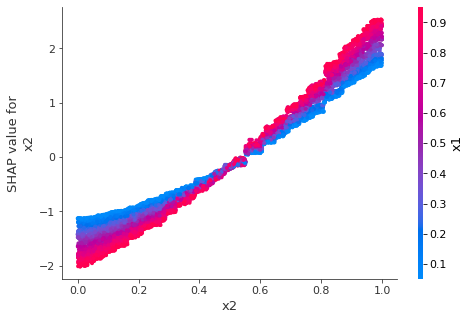

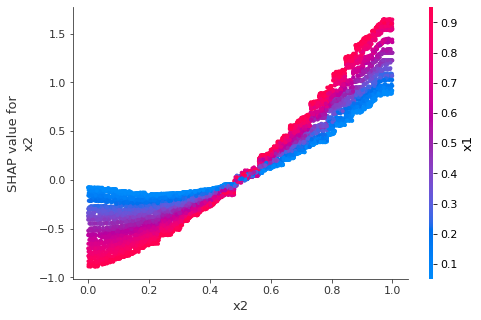

In [21]:
shap.dependence_plot("x2", shap3, X)
shap.dependence_plot("x2", new_shap_final, X)

<AxesSubplot:ylabel='Frequency'>

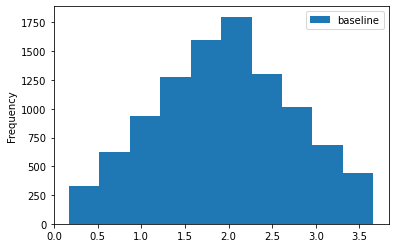

In [22]:
new_shap[["baseline"]].plot(kind = "hist")

In [23]:
shap3_ex.expected_value

2.302656

In [24]:
new_shap[["baseline"]].mean()

baseline    1.95246
dtype: float32

In [25]:
shap1_ex.expected_value

0.9916429

In [26]:
shap2_ex.expected_value

1.9689213

In [27]:
bst1.predict(d1).mean()

0.9916429

In [28]:
bst2.predict(d2).mean()

1.9689211

In [29]:
bst3.predict(d3).mean()

2.3026557

## Issues with the bias term (or rather, the average prediction term)

In [30]:
resid = y3 - bst3.predict(d3)
print("MAE:", np.absolute(resid).mean())
resid2 = resid**2
print("MSE:", resid2.mean())

MAE: 0.07812367533357804
MSE: 0.01102077734254993


In [31]:
# Set the Seed
np.random.seed(250)

# Get the Predictors
x1 = np.random.uniform(low = -1, high = 1, size = 10000)
x2 = np.random.uniform(low = -1, high = 1, size = 10000)
d = {"x1":x1, "x2":x2}
X = pd.DataFrame(data = d)

# Get the three different responses
y1 = x1 + x2
y2 = 2 * x1 + 2 * x2
y3 = (x1 + x2) * (2 * x1 + 2 * x2)

# Make the data for the 3 models
d1 = xgb.DMatrix(X, label=y1)
d2 = xgb.DMatrix(X, label=y2)
d3 = xgb.DMatrix(X, label=y3)

X.head()

,x1,x2
0,-0.570441,0.059004
1,-0.454673,-0.290564
2,-0.285321,-0.154775
3,0.237249,0.925364
4,0.282682,0.872953


In [32]:
param = {'max_depth': 5, 'eta': 0.3, 'objective': 'reg:squarederror', "eval_metric":"mae", "alpha":0.1, "gamma":0.1}

bst1 = xgb.train(param, d1, 10)
bst2 = xgb.train(param, d2, 10)
bst3 = xgb.train(param, d3, 10)

In [33]:
resid = y3 - bst3.predict(d3)
print("MAE bst3:", np.absolute(resid).mean())
resid2 = resid**2
print("MSE bst3:", resid2.mean())

MAE bst3: 0.14069484479424602
MSE bst3: 0.033318493473250776


In [34]:
resid1 = y1 - bst1.predict(d1)
print("MAE bst1:", np.absolute(resid1).mean())
resid1_2 = resid1**2
print("MSE:", resid1_2.mean())

MAE bst1: 0.038056403354328805
MSE: 0.002266255856144845


In [35]:
shap1_ex_new = shap.TreeExplainer(bst1)
shap1_new = shap1_ex.shap_values(X)
shap2_ex_new = shap.TreeExplainer(bst2)
shap2_new = shap2_ex.shap_values(X)
shap3_ex_new = shap.TreeExplainer(bst3)
shap3_new = shap3_ex.shap_values(X)

In [36]:
print("SHAP bias term for model 1 trained on Unif[0,1]: ", shap1_ex.expected_value)
print("SHAP bias term for model 1 trained on Unif[-1,1]:", shap1_ex_new.expected_value)
print("SHAP bias term for model 2 trained on Unif[0,1]: ", shap2_ex.expected_value)
print("SHAP bias term for model 2 trained on Unif[-1,1]:", shap2_ex_new.expected_value)
print("SHAP bias term for model 3 trained on Unif[0,1]: ", shap3_ex.expected_value)
print("SHAP bias term for model 3 trained on Unif[-1,1]:", shap3_ex_new.expected_value)

SHAP bias term for model 1 trained on Unif[0,1]:  0.9916429
SHAP bias term for model 1 trained on Unif[-1,1]: [0.02510047]
SHAP bias term for model 2 trained on Unif[0,1]:  1.9689213
SHAP bias term for model 2 trained on Unif[-1,1]: [0.0358094]
SHAP bias term for model 3 trained on Unif[0,1]:  2.302656
SHAP bias term for model 3 trained on Unif[-1,1]: [1.31167182]


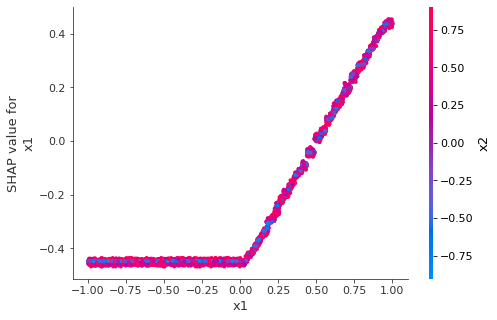

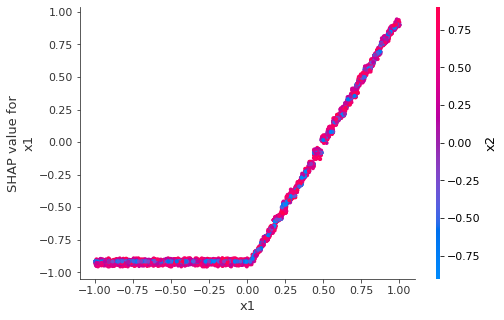

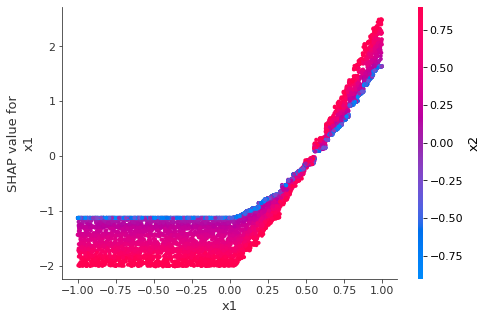

In [37]:
shap.dependence_plot("x1", shap1_new, X)
shap.dependence_plot("x1", shap2_new, X)
shap.dependence_plot("x1", shap3_new, X)

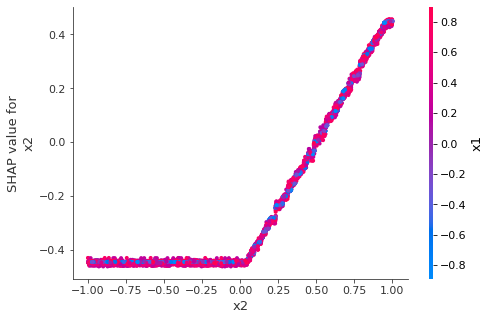

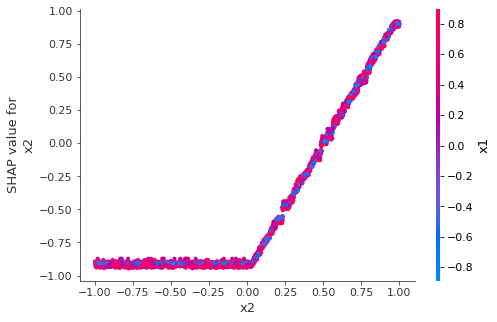

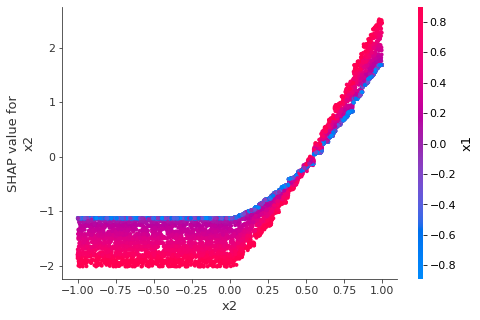

In [38]:
shap.dependence_plot("x2", shap1_new, X)
shap.dependence_plot("x2", shap2_new, X)
shap.dependence_plot("x2", shap3_new, X)

## Make "test" data and see what that does

In [39]:
# Set the Seed (different than last time, for the test data)
np.random.seed(16)

# Get the Predictors
x1 = np.random.uniform(low = -1, high = 1, size = 1000)
x2 = np.random.uniform(low = -1, high = 1, size = 1000)
d = {"x1":x1, "x2":x2}
X = pd.DataFrame(data = d)

# Get the three different responses
y1 = x1 + x2
y2 = 2 * x1 + 2 * x2
y3 = (x1 + x2) * (2 * x1 + 2 * x2)

# Make the data for the 3 models
d1_test = xgb.DMatrix(X, label=y1)
d2_test = xgb.DMatrix(X, label=y2)
d3_test = xgb.DMatrix(X, label=y3)

X.head()

,x1,x2
0,-0.553418,-0.001497
1,0.046327,-0.122636
2,0.101403,0.548468
3,-0.908796,0.987804
4,-0.278542,0.212804


<AxesSubplot:ylabel='Frequency'>

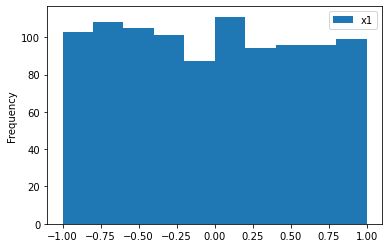

In [40]:
X[["x1"]].plot(kind = "hist")

In [41]:
shap3_new_test = shap3_ex_new.shap_values(X)

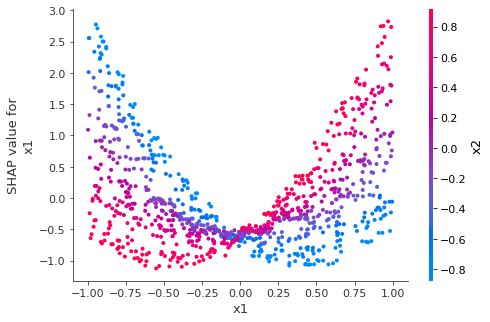

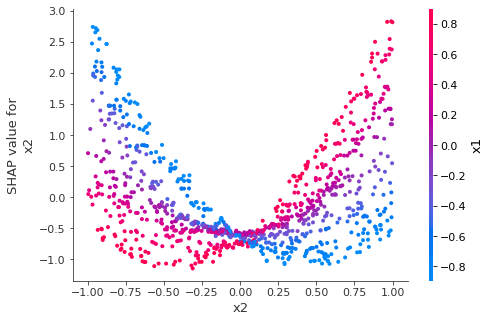

In [42]:
shap.dependence_plot("x1", shap3_new_test, X)
shap.dependence_plot("x2", shap3_new_test, X)

In [43]:
shap3_ex_new.expected_value

1.3116717

## Is the expected value actually the mean prediction?

I think it may not be, since there is a slight discrepancy above.  I be with less draws from the random distribution we would see it a lot stronger.

In [44]:
# Set the Seed
np.random.seed(250)

# Get the Predictors
x1 = np.random.uniform(low = -1, high = 1, size = 100)
x2 = np.random.uniform(low = -1, high = 1, size = 100)
d = {"x1":x1, "x2":x2}
X = pd.DataFrame(data = d)

# Get the three different responses
y1 = x1 + x2
y2 = 2 * x1 + 2 * x2
y3 = (x1 + x2) * (2 * x1 + 2 * x2)

# Make the data for the 3 models
d1 = xgb.DMatrix(X, label=y1)
d2 = xgb.DMatrix(X, label=y2)
d3 = xgb.DMatrix(X, label=y3)

param = {'max_depth': 5, 'eta': 0.3, 'objective': 'reg:squarederror', "eval_metric":"mae", "alpha":0.1, "gamma":0.1}

bst1 = xgb.train(param, d1, 10)
bst2 = xgb.train(param, d2, 10)
bst3 = xgb.train(param, d3, 10)

shap1_ex_test = shap.TreeExplainer(bst1)
shap2_ex_test = shap.TreeExplainer(bst2)
shap3_ex_test = shap.TreeExplainer(bst3)

print("Model 1 SHAP expected value:", shap1_ex_test.expected_value)
print("Model 2 SHAP expected value:", shap2_ex_test.expected_value)
print("Model 3 SHAP expected value:", shap3_ex_test.expected_value)

Model 1 SHAP expected value: [0.08067601]
Model 2 SHAP expected value: [0.14294577]
Model 3 SHAP expected value: [1.37573341]


In [97]:
print("Model 1 mean prediction:", bst1.predict(d1).mean())
print("Model 2 mean prediction:", bst2.predict(d1).mean())
print("Model 3 mean prediction:", bst3.predict(d1).mean())

Model 1 mean prediction: 0.08067598
Model 2 mean prediction: 0.14294577
Model 3 mean prediction: 1.3757335
